In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm

In [2]:
# Parameters of the Axelrod model
L_values = [32]  # size of the grid
F_values = [3, 10]  # number of features
q = 400  # number of traits per feature

# Parameter for the noise
noise = [0.01]  # probability of random cultural drift

# Parameter for the mass media influence
media = [0.01]  # probability of adopting the global culture

In [3]:
def initialize_culture_grid(L, F, q):
    """
    Initialize the culture grid.

    Parameters:
        L (int): size of the grid
        F (int): number of features
        q (int): number of traits per feature

    Returns:
        np.array: the culture grid
    """
    return np.random.randint(q, size=(L, L, F))

def calculate_global_culture(culture_grid):
    """
    Calculate the most common culture in the culture grid.

    Parameters:
        culture_grid (np.array): the culture grid

    Returns:
        np.array: the most common culture
    """
    L, _, F = culture_grid.shape
    culture_int = np.sum(culture_grid * (q ** np.arange(F)), axis=2)
    unique_vals, counts = np.unique(culture_int, return_counts=True)
    most_common_culture_int = unique_vals[np.argmax(counts)]
    most_common_culture = np.zeros(F)
    for i in range(F-1, -1, -1):
        most_common_culture[i] = most_common_culture_int % q
        most_common_culture_int //= q
    return most_common_culture

def simulation_step(culture_grid, L):
    """
    Perform a simulation step.

    Parameters:
        culture_grid (np.array): the culture grid
        L (int): size of the grid
        F (int): number of features
        q (int): number of traits per feature

    Returns:
        np.array: the updated culture grid
    """
    # Randomly select an agent
    x, y = np.random.randint(L, size=2)

    # Randomly select a neighbor
    dx, dy = np.random.choice([-1, 0, 1], size=2)
    nx, ny = (x + dx) % L, (y + dy) % L  # periodic boundary conditions

    # If they share at least one cultural feature
    if any(culture_grid[x, y, :] == culture_grid[nx, ny, :]):
        # The agent adopts one differing feature from the neighbor
        differing_features = np.where(culture_grid[x, y, :] != culture_grid[nx, ny, :])[0]
        if len(differing_features) > 0:
            f = np.random.choice(differing_features)
            culture_grid[x, y, f] = culture_grid[nx, ny, f]

    return culture_grid

def simulation_step_with_noise(culture_grid, L, noise):
    """
    Perform a simulation step with noise.

    Parameters:
        culture_grid (np.array): the culture grid
        L (int): size of the grid
        F (int): number of features
        q (int): number of traits per feature
        noise (float): probability of random cultural drift

    Returns:
        np.array: the updated culture grid
    """
    # Perform a normal simulation step
    simulation_step(culture_grid, L)

    # With a small probability, an agent randomly changes one of its features
    if np.random.rand() < noise:
        x, y = np.random.randint(L, size=2)
        f = np.random.randint(F)
        culture_grid[x, y, f] = np.random.randint(q)

    return culture_grid

def simulation_step_with_noise_and_media(culture_grid, L, media):
    """
    Perform a simulation step with noise and media influence.

    Parameters:
        culture_grid (np.array): the culture grid
        L (int): size of the grid
        F (int): number of features
        q (int): number of traits per feature
        noise (float): probability of random cultural drift
        media (float): probability of adopting the global culture

    Returns:
        np.array: the updated culture grid
    """
    # The global culture
    global_culture = calculate_global_culture(culture_grid)

    # Perform a simulation step with noise
    simulation_step_with_noise(culture_grid, L)

    # With a small probability, an agent adopts the global culture
    if np.random.rand() < media:
        x, y = np.random.randint(L, size=2)
        culture_grid[x, y, :] = global_culture

    return culture_grid

def calculate_Smax_norm(culture_grid):
    """
    Calculate the size of the largest homogeneous domain (Smax).

    Parameters:
        culture_grid (np.array): the culture grid

    Returns:
        int: Smax value
    """
    L, _, F = culture_grid.shape
    culture_int = np.sum(culture_grid * (q ** np.arange(F)), axis=2)
    unique_vals, counts = np.unique(culture_int, return_counts=True)
    max_count = np.max(counts)
    Smax_norm = max_count / (L ** 2)

    return Smax_norm

In [4]:
#####
# start the base simulation plotting for each q
#####

Smax_final_dict = {}
Smax_norm = []
q_values = range(10, q, 5)

# Initialize progress bar for the entire simulation
total_progress = tqdm(total=len(L_values)*len(F_values), desc="Total Simulation", position=0)

for L in L_values:

    for F in F_values:

        Smax_final = []  # Empty the list at the beginning of each iteration on F

        # Initialize progress bar for each run
        run_progress = tqdm(total=len(q_values), desc=f"Simulation for L={L}, F={F}", position=1, leave=False)

        for index, n in enumerate(q_values):

            # Update the progress bar for each run
            run_progress.update()

            # Initialize the culture grid
            culture_grid = initialize_culture_grid(L, F, n)

            # Reset Smax_norm at the beginning of each simulation
            Smax_norm = []

            # Start the simulation
            for _ in range(10000000):
                culture_grid = simulation_step(culture_grid, L)
                T = calculate_Smax_norm(culture_grid)/(L**2)
                Smax_norm.append(T)

            # Calculate Smax for this value of q
            SF = np.max(Smax_norm)
            Smax_final.append(SF)

        # Store Smax_final for each combination of L and F
        Smax_final_dict[(L, F)] = Smax_final

        # Update the progress bar for the entire simulation
        total_progress.update()

# Close the progress bars
run_progress.close()
total_progress.close()

Simulation for L=32, F=10:   0%|          | 0/78 [00:00<?, ?it/s]
                                                                             
Total Simulation: 100%|██████████| 2/2 [37:22:32<00:00, 67276.09s/it]          


In [ ]:
#####
# start the base simulation
#####

Smax_norm = []
q_values = range(10, q, 10)
Smax_final_dict = {}

for L in L_values:

    Smax_final = []  # Empty the list at the beginning of each iteration on L

    for F in F_values:

        for index, n in enumerate(q_values):

            # Initialize the culture grid
            culture_grid = initialize_culture_grid(L, F, n)

            # Compute a unique integer for each possible culture
            culture_integers = np.sum(culture_grid * (n ** np.arange(F)), axis=2)

            # Generate a random colormap
            cmap = colors.ListedColormap(np.random.rand(n**F, 3))

            # Only plot for the first and last q values
            if index == 0 or index == len(q_values) - 1:
                # Create a figure with two subplots
                fig, axs = plt.subplots(1, 2, figsize=(12, 6))

                # Visualize the initial state of the culture grid
                axs[0].imshow(culture_integers, cmap=cmap)
                axs[0].set_title(f'Initial state of the culture grid (q={n})')

            # Start the simulation
            for _ in range(100):
                culture_grid = simulation_step(culture_grid, L)
                T = calculate_Smax_norm(culture_grid)/(L**2)
                Smax_norm.append(T)

            SF = np.max(Smax_norm)
            Smax_final.append(SF)

            # Re-compute a unique integer for each possible culture
            culture_integers = np.sum(culture_grid * (q ** np.arange(F)), axis=2)

            # Only plot for the first and last q values
            if index == 0 or index == len(q_values) - 1:
                # Visualize the final state of the culture grid
                axs[1].imshow(culture_integers, cmap=cmap)
                axs[1].set_title(f'Final state of the culture grid (q={n})')
                plt.show()

        Smax_final_dict[L] = Smax_final

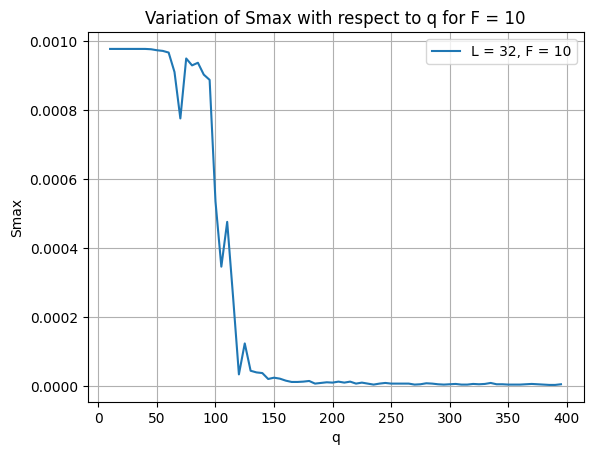

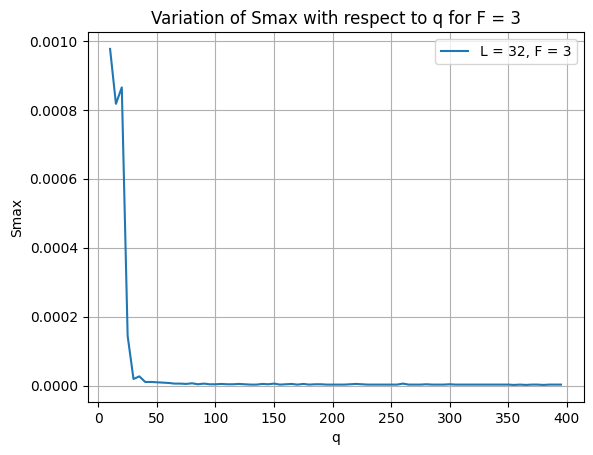

In [5]:
# Creating separate plots for each value of F, combining all values of L within each plot
F_values_set = set(F for L, F in Smax_final_dict.keys())

for F in F_values_set:
    plt.figure()

    for (L, F_key), Smax_final in Smax_final_dict.items():
        if F_key == F:
            # Add each plot to the same figure
            plt.plot(list(q_values), Smax_final, label=f"L = {L}, F = {F}")

    # Adding labels, title, legend, and grid
    plt.xlabel('q')
    plt.ylabel('Smax')
    plt.title(f'Variation of Smax with respect to q for F = {F}')
    plt.legend()
    plt.grid(True)

    # Display the figure
    plt.show()
